In [2]:
import h5py
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback

from scipy.optimize import minimize
from scipy.misc import derivative
from tqdm import tqdm 

from utils import *

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
# Load data
hf = h5py.File('../XPFS_data/high_kbar/high_kbar.h5', 'r')

In [6]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

true = list(np.round(np.linspace(0.1, 0.95, 18), 2))          # desired contrast in the interval 0-1

ml_preds = [] 

# Loop through 10 cnn models 
for i in tqdm(range(1, 11)):
    
    # Load model 
    model = tf.keras.models.load_model('../models/full_range_ensemble/cnn_' + str(i))
    ml_pred = []
    
    # Loop through 18 validation datasets 
    for element in true:
        X_ADU_test = np.array(hf['test']['valid_detector_' + str(element)])                     
        photon_map = np.round(model.predict(X_ADU_test))
        data = np.reshape(photon_map, (len(photon_map), -1))
        k = np.reshape(data, -1)
        kbar = np.repeat(np.mean(data, axis=1),900) 
        result = minimize(nll,0.8,args=(k,kbar),bounds=((0.001,1.0),))
        ml_pred.append(result.x[0])

    ml_preds.append(ml_pred)
    
ml_preds = np.array(ml_preds)

100%|██████████| 10/10 [04:11<00:00, 25.15s/it]


<Figure size 640x480 with 0 Axes>

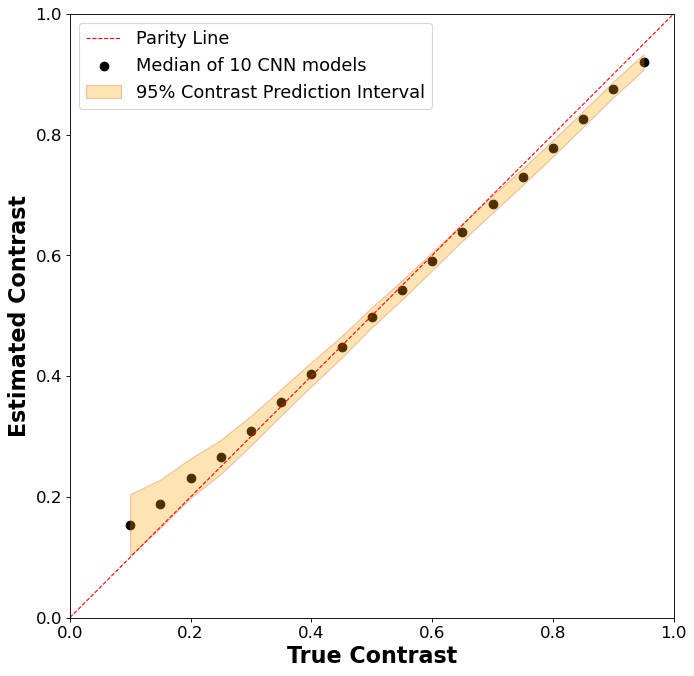

In [8]:
figure(figsize=(10, 10), dpi=80)

point_prediction = np.median(ml_preds,axis=0)
std = np.std(ml_preds,axis=0)
error_bar = 2.262*std # t-distribution scaling factor 

plt.scatter(true, point_prediction, color='black',linewidth=1,  label = 'Median of 10 CNN models',s=60)
plt.fill_between(true, point_prediction - error_bar, point_prediction + error_bar,alpha=0.3, edgecolor='#CC4F1B', facecolor='orange', label='95% Contrast Prediction Interval')
plt.plot(np.linspace(0,1), np.linspace(0,1), 'r--',linewidth=1.0, label = 'Parity Line')
plt.xlabel("True Contrast", fontsize=20, fontweight = "bold")
plt.ylabel("Estimated Contrast", fontsize=20, fontweight = "bold")
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(fontsize=16)
plt.show()